In [1]:
import pandas as pd
import numpy as np
import statistics
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
# one-hot encode braid word and pad to consistent length
def encode_braid(braid, maxStrands, maxCrossings):

    b = tf.keras.utils.to_categorical(braid, num_classes=maxStrands*2)

    for i in range(maxCrossings - len(b)):
            b = np.append(b, [np.zeros(maxStrands*2)], axis=0)

    return b

In [3]:
# turn list of lists of equivalent braids with corresponding answers into trainable data
def parse_equivalent_braids(allBraids, answers, maxStrands, maxCrossings):

    x_data = []
    y_data = []

    # zip list of equivalent braids with same label
    for equivalentBraids, answer in zip(allBraids, answers):
        for braid in equivalentBraids:
            x_data.append(braid)
            y_data.append(answer)

    # encode each braid word
    x_data = [encode_braid(x, maxStrands, maxCrossings) for x in x_data]

    return np.asarray(x_data), np.asarray(y_data)

In [4]:
# read pre-parsed knot data with braid words and equivalent braids

knot_data = pd.read_csv('../data/knot_data_jones.csv')
knot_data["Equivalent Braids"] = knot_data["Equivalent Braids"].apply(eval)
knot_data["Jones"] = knot_data["Jones"].apply(eval)

In [5]:
eq = knot_data["Equivalent Braids"]

maxCrossings = max([max([len(braid) for braid in braids]) for braids in eq])
maxStrands = max([max([max([abs(b) for b in braid]) for braid in braids]) for braids in eq])

minPower = -13
maxPower = 16
nCoefficients = maxPower - minPower + 1

In [6]:
# normalize y values by dividing by avg stdev of coefficients
avg_stdev = statistics.mean([statistics.stdev(coefficients) for coefficients in knot_data["Jones"]])

In [7]:
knot_data["Jones Normalized"] = knot_data["Jones"].apply(lambda l: [x / avg_stdev for x in l])

In [8]:
# split dataset for training

train_split = .8

train_data = knot_data.sample(frac=train_split)
test_data = knot_data.drop(train_data.index)

x_train, y_train = parse_equivalent_braids(train_data["Equivalent Braids"],
                    train_data["Jones Normalized"], maxStrands, maxCrossings)

x_test, y_test = parse_equivalent_braids(test_data["Equivalent Braids"],
                    test_data["Jones Normalized"], maxStrands, maxCrossings)

In [9]:
# build model from functional api
inputs = keras.Input(shape=(maxCrossings, maxStrands*2))

# linear version
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(nCoefficients)(x)

In [10]:
model = keras.Model(inputs=inputs, outputs=outputs, 
    name="jones_polynomial")

model.compile(loss="mean_squared_error", optimizer="adam")

model.summary()

Model: "jones_polynomial"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 12)]          0         
                                                                 
 flatten (Flatten)           (None, 228)               0         
                                                                 
 dense (Dense)               (None, 64)                14656     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 30)                1950      
                                                                 
Total params: 20,766
Trainable params: 20,766
Non-trainable params: 0
_________________________________________________________________


In [96]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=.01)

In [97]:
start_time = time.time()

history_linear = model.fit(
    x_train,
    y_train,
    validation_split=.1,
    batch_size=32,
    epochs=50,
    callbacks=[earlyStop],
    verbose=1
)

linear_time = time.time() - start_time
linear_eval = model.evaluate(x_test, y_test)

Epoch 1/50
2140/2140 [==============================] - 1s 587us/step - loss: 1.3021 - val_loss: 1.2566
Epoch 2/50
2140/2140 [==============================] - 1s 599us/step - loss: 1.1073 - val_loss: 1.0646
Epoch 3/50
2140/2140 [==============================] - 1s 547us/step - loss: 0.9088 - val_loss: 0.9758
Epoch 4/50
2140/2140 [==============================] - 1s 566us/step - loss: 0.8024 - val_loss: 0.9538
Epoch 5/50
2140/2140 [==============================] - 1s 547us/step - loss: 0.7398 - val_loss: 0.9056
Epoch 6/50
2140/2140 [==============================] - 1s 546us/step - loss: 0.6949 - val_loss: 0.8957
Epoch 7/50
2140/2140 [==============================] - 1s 540us/step - loss: 0.6592 - val_loss: 0.8841
Epoch 8/50
2140/2140 [==============================] - 1s 539us/step - loss: 0.6326 - val_loss: 0.8727
Epoch 9/50
2140/2140 [==============================] - 1s 538us/step - loss: 0.6065 - val_loss: 0.8531
Epoch 10/50
2140/2140 [==============================] - 1s 553u

In [34]:
# simple RNN

inputs = keras.Input(shape=(maxCrossings, maxStrands*2))

x = layers.Masking()(inputs)
x = layers.SimpleRNN(128)(x)

outputs = layers.Dense(nCoefficients)(x)

model = keras.Model(inputs=inputs, outputs=outputs, 
    name="jones_polynomial")

model.compile(loss="mean_squared_error", optimizer="adam")


In [35]:
start_time = time.time()

history_simpleRNN = model.fit(
    x_train,
    y_train,
    validation_split=.1,
    batch_size=32,
    epochs=50,
    callbacks=[earlyStop],
    verbose=1
)

simpleRNN_time = time.time() - start_time
simpleRNN_eval = model.evaluate(x_test, y_test)

Epoch 1/50
2139/2139 [==============================] - 9s 4ms/step - loss: 1.3365 - val_loss: 1.2417
Epoch 2/50
2139/2139 [==============================] - 9s 4ms/step - loss: 1.3314 - val_loss: 1.2432
Epoch 3/50
2139/2139 [==============================] - 9s 4ms/step - loss: 1.3277 - val_loss: 1.2323
Epoch 4/50
2139/2139 [==============================] - 9s 4ms/step - loss: 1.3263 - val_loss: 1.2337


In [36]:
# simple RNN

inputs = keras.Input(shape=(maxCrossings, maxStrands*2))

x = layers.Masking()(inputs)
x = layers.LSTM(128)(x)

outputs = layers.Dense(nCoefficients)(x)

model = keras.Model(inputs=inputs, outputs=outputs, 
    name="jones_polynomial")

model.compile(loss="mean_squared_error", optimizer="adam")


In [37]:
start_time = time.time()

history_lstm = model.fit(
    x_train,
    y_train,
    validation_split=.1,
    batch_size=32,
    epochs=50,
    callbacks=[earlyStop],
    verbose=1
)

lstm_time = time.time() - start_time

Epoch 1/50
2139/2139 [==============================] - 23s 10ms/step - loss: 1.2500 - val_loss: 1.0870
Epoch 2/50
2139/2139 [==============================] - 21s 10ms/step - loss: 1.0286 - val_loss: 0.8958
Epoch 3/50
2139/2139 [==============================] - 21s 10ms/step - loss: 0.8258 - val_loss: 0.7352
Epoch 4/50
2139/2139 [==============================] - 21s 10ms/step - loss: 0.7000 - val_loss: 0.6559
Epoch 5/50
2139/2139 [==============================] - 21s 10ms/step - loss: 0.6110 - val_loss: 0.6221
Epoch 6/50
2139/2139 [==============================] - 21s 10ms/step - loss: 0.5501 - val_loss: 0.5587
Epoch 7/50
2139/2139 [==============================] - 21s 10ms/step - loss: 0.4980 - val_loss: 0.5477
Epoch 8/50
2139/2139 [==============================] - 21s 10ms/step - loss: 0.4529 - val_loss: 0.5295
Epoch 9/50
2139/2139 [==============================] - 21s 10ms/step - loss: 0.4172 - val_loss: 0.5134
Epoch 10/50
2139/2139 [==============================] - 21s 10m

In [40]:
lstm_eval = model.evaluate(x_test, y_test)

595/595 [==============================] - 2s 3ms/step - loss: 0.4806


In [17]:
# GRU

inputs = keras.Input(shape=(maxCrossings, maxStrands*2))

x = layers.Masking()(inputs)
x = layers.GRU(128)(x)

outputs = layers.Dense(nCoefficients)(x)

model = keras.Model(inputs=inputs, outputs=outputs, 
    name="jones_polynomial")

model.compile(loss="mean_squared_error", optimizer="adam")


In [52]:
start_time = time.time()

history_gru = model.fit(
    x_train,
    y_train,
    validation_split=.1,
    batch_size=32,
    epochs=50,
    callbacks=[earlyStop],
    verbose=1
)

gru_time = time.time() - start_time
gru_eval = model.evaluate(x_test, y_test)

Epoch 1/50
2140/2140 [==============================] - 21s 9ms/step - loss: 1.2770 - val_loss: 1.2625
Epoch 2/50
2140/2140 [==============================] - 18s 9ms/step - loss: 1.0848 - val_loss: 1.0086
Epoch 3/50
2140/2140 [==============================] - 19s 9ms/step - loss: 0.8829 - val_loss: 0.9168
Epoch 4/50
2140/2140 [==============================] - 19s 9ms/step - loss: 0.7635 - val_loss: 0.8797
Epoch 5/50
2140/2140 [==============================] - 19s 9ms/step - loss: 0.6807 - val_loss: 0.7882
Epoch 6/50
2140/2140 [==============================] - 19s 9ms/step - loss: 0.6169 - val_loss: 0.7772
Epoch 7/50
2140/2140 [==============================] - 19s 9ms/step - loss: 0.5618 - val_loss: 0.6894
Epoch 8/50
2140/2140 [==============================] - 20s 9ms/step - loss: 0.5189 - val_loss: 0.6620
Epoch 9/50
2140/2140 [==============================] - 20s 9ms/step - loss: 0.4826 - val_loss: 0.6249
Epoch 10/50
2140/2140 [==============================] - 20s 9ms/step - l

In [19]:
# GRU + dense

inputs = keras.Input(shape=(maxCrossings, maxStrands*2))

x = layers.Masking()(inputs)
x = layers.GRU(128, return_sequences=True)(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)

outputs = layers.Dense(nCoefficients)(x)

model = keras.Model(inputs=inputs, outputs=outputs, 
    name="jones_polynomial")

model.compile(loss="mean_squared_error", optimizer="adam")

model.summary()

Model: "jones_polynomial"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 19, 12)]          0         
                                                                 
 masking_1 (Masking)         (None, 19, 12)            0         
                                                                 
 gru_1 (GRU)                 (None, 19, 128)           54528     
                                                                 
 flatten_1 (Flatten)         (None, 2432)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               311424    
                                                                 
 dense_5 (Dense)             (None, 30)                3870      
                                                                 
Total params: 369,822
Trainable params: 369,822
No

In [59]:
start_time = time.time()

history_gru_dense = model.fit(
    x_train,
    y_train,
    validation_split=.1,
    batch_size=32,
    epochs=50,
    callbacks=[earlyStop],
    verbose=1
)

gru_dense_time = time.time() - start_time
gru_dense_eval = model.evaluate(x_test, y_test)

Epoch 1/50
2140/2140 [==============================] - 23s 10ms/step - loss: 1.3212 - val_loss: 1.2833
Epoch 2/50
2140/2140 [==============================] - 23s 11ms/step - loss: 1.2986 - val_loss: 1.2642
Epoch 3/50
2140/2140 [==============================] - 21s 10ms/step - loss: 1.1636 - val_loss: 1.1675
Epoch 4/50
2140/2140 [==============================] - 22s 10ms/step - loss: 0.9297 - val_loss: 0.9477
Epoch 5/50
2140/2140 [==============================] - 23s 11ms/step - loss: 0.7702 - val_loss: 0.8161
Epoch 6/50
2140/2140 [==============================] - 21s 10ms/step - loss: 0.6586 - val_loss: 0.7331
Epoch 7/50
2140/2140 [==============================] - 22s 10ms/step - loss: 0.5811 - val_loss: 0.7302
Epoch 8/50
2140/2140 [==============================] - 20s 10ms/step - loss: 0.5235 - val_loss: 0.6801
Epoch 9/50
2140/2140 [==============================] - 20s 10ms/step - loss: 0.4788 - val_loss: 0.6525
Epoch 10/50
2140/2140 [==============================] - 21s 10m

In [21]:
# GRU + GRU

inputs = keras.Input(shape=(maxCrossings, maxStrands*2))

x = layers.Masking()(inputs)
x = layers.GRU(128, return_sequences=True)(x)
x = layers.GRU(64)(x)

outputs = layers.Dense(nCoefficients)(x)

model = keras.Model(inputs=inputs, outputs=outputs, 
    name="jones_polynomial")

model.compile(loss="mean_squared_error", optimizer="adam")

model.summary()

Model: "jones_polynomial"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 19, 12)]          0         
                                                                 
 masking_2 (Masking)         (None, 19, 12)            0         
                                                                 
 gru_2 (GRU)                 (None, 19, 128)           54528     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 30)                1950      
                                                                 
Total params: 93,726
Trainable params: 93,726
Non-trainable params: 0
_________________________________________________________________


In [61]:
start_time = time.time()

history_gru_stack = model.fit(
    x_train,
    y_train,
    validation_split=.1,
    batch_size=32,
    epochs=50,
    callbacks=[earlyStop],
    verbose=1
)

gru_stack_time = time.time() - start_time
gru_stack_eval = model.evaluate(x_test, y_test)

Epoch 1/50
2140/2140 [==============================] - 43s 19ms/step - loss: 1.1864 - val_loss: 1.0629
Epoch 2/50
2140/2140 [==============================] - 39s 18ms/step - loss: 0.8489 - val_loss: 0.8192
Epoch 3/50
2140/2140 [==============================] - 39s 18ms/step - loss: 0.6776 - val_loss: 0.7519
Epoch 4/50
2140/2140 [==============================] - 36s 17ms/step - loss: 0.5637 - val_loss: 0.6459
Epoch 5/50
2140/2140 [==============================] - 38s 18ms/step - loss: 0.4802 - val_loss: 0.5476
Epoch 6/50
2140/2140 [==============================] - 39s 18ms/step - loss: 0.4064 - val_loss: 0.4945
Epoch 7/50
2140/2140 [==============================] - 40s 19ms/step - loss: 0.3590 - val_loss: 0.4846
Epoch 8/50
2140/2140 [==============================] - 37s 17ms/step - loss: 0.3184 - val_loss: 0.4432
Epoch 9/50
2140/2140 [==============================] - 38s 18ms/step - loss: 0.2828 - val_loss: 0.4148
Epoch 10/50
2140/2140 [==============================] - 38s 18m

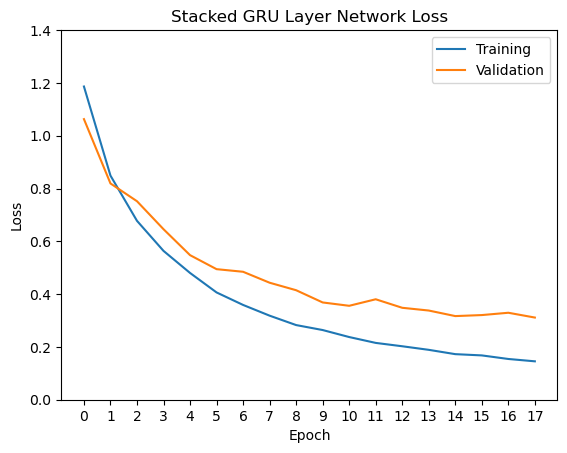

In [112]:
history = history_gru_stack

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Stacked GRU Layer Network Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(history.history["loss"])))
plt.ylim([0,1.4])
plt.legend(['Training', 'Validation'])
plt.show()

In [15]:
from keras.utils.vis_utils import plot_model
import pydot

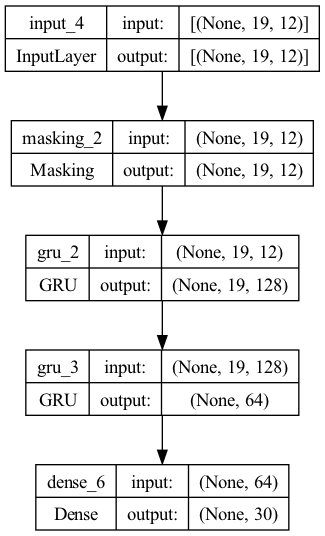

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [14]:
x_train.shape

(76066, 19, 12)

In [15]:
knot_data

,Unnamed: 0,Name,Braid Notation,Volume,Braid List,Equivalent Braids,Jones,Jones Normalized
0,0,3_1,{1;1;1},0.000000,"[1, 1, 1]","[[-1, 2, 2, 2, 1, -2], [1, 1, 1, 2, 3], [1, -1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,4_1,{1;-2;1;-2},2.029883,"[1, -2, 1, -2]","[[-1, -2, -3, -4, 5, 4, 3, 2, -4, 1, -3, -5, -...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 1, -1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,5_1,{1;1;1;1;1},0.000000,"[1, 1, 1, 1, 1]","[[1, 1, 1, 2, 1, 3, 1], [-1, 2, 2, -3, -2, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,5_2,{1;1;1;2;-1;2},2.828122,"[1, 1, 1, 2, -1, 2]","[[1, -1, 1, 2, 1, 1, 1, 2, -1, -1], [-1, 2, -3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,6_1,{1;1;2;-1;-3;2;-3},3.163963,"[1, 1, 2, -1, -3, 2, -3]","[[-1, 2, -3, -4, -5, -4, -3, 2, 1, -2, 3, 2, 4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, -1, 2, -2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2972,2972,12n_884,{1;-2;1;2;3;-2;3;-4;2;-4;-3;2;-3;4},15.585360,"[1, -2, 1, 2, 3, -2, 3, -4, 2, -4, -3, 2, -3, 4]","[[1, -1, -2, 1, -3, 2, -3, 2, -4, -2, -4, 2, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 4, -7, 11, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2973,2973,12n_885,{-1;2;-3;4;-1;3;-2;-3;2;4;-3;2;-3;4},18.918055,"[-1, 2, -3, 4, -1, 3, -2, -3, 2, 4, -3, 2, -3, 4]","[[-1, 2, -1, -3, 2, -3, 4, -3, -2, -2, 2, 3, 3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, -7, 14, -20, 24...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2974,2974,12n_886,{1;-2;1;2;3;-2;3;4;-2;4;3;-2;3;-4},18.940373,"[1, -2, 1, 2, 3, -2, 3, 4, -2, 4, 3, -2, 3, -4]","[[-1, -2, 1, -3, 4, -5, 4, 3, -5, 2, 3, 4, -5,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 5, -11, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2975,2975,12n_887,{1;-2;1;-2;1;-2;1;1;2;2;2;1},17.303379,"[1, -2, 1, -2, 1, -2, 1, 1, 2, 2, 2, 1]","[[1, 2, 3, 2, 4, 3, 2, -4, 2, 1, 1, -2, 1, -2,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
linear_eval

NameError: name 'linear_eval' is not defined